## Load Packages

In [110]:
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.preprocessing import PowerTransformer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,  TransformedTargetRegressor

pd.pandas.set_option('display.max_columns', None)

## Import Data

In [111]:
train = pd.read_csv('data/train.csv', index_col='Id')
test = pd.read_csv('data/test.csv', index_col='Id')

print(f'Shape of training data: {train.shape}')
print(f'Shape of testing data: {test.shape}')

Shape of training data: (1460, 80)
Shape of testing data: (1459, 79)


In [112]:
rgx = '(?<=^[A-Z]{2})(?=[A-Z]{1}[a-z])|(?<=[a-z]{1})(?=[A-Z])|(?=[0-9]$)'

# standardize columns names to lower case with underscore to separate words
train.columns = train.columns.map(lambda x: re.sub(string=x, pattern=rgx, repl="_").lower())
test.columns  = test.columns.map(lambda x: re.sub(string=x, pattern=rgx, repl="_").lower())

print(f'Columns of training data: {train.columns.tolist()}')

Columns of training data: ['ms_sub_class', 'ms_zoning', 'lot_frontage', 'lot_area', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'roof_style', 'roof_matl', 'exterior1st', 'exterior2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type_1', 'bsmt_fin_sf_1', 'bsmt_fin_type_2', 'bsmt_fin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abv_gr', 'kitchen_abv_gr', 'kitchen_qual', 'tot_rms_abv_grd', 'functional', 'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area', 'garage_qual', 'garage_cond', 'paved_dr

## Variable Types

In [113]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ms_sub_class     1460 non-null   int64  
 1   ms_zoning        1460 non-null   object 
 2   lot_frontage     1201 non-null   float64
 3   lot_area         1460 non-null   int64  
 4   street           1460 non-null   object 
 5   alley            91 non-null     object 
 6   lot_shape        1460 non-null   object 
 7   land_contour     1460 non-null   object 
 8   utilities        1460 non-null   object 
 9   lot_config       1460 non-null   object 
 10  land_slope       1460 non-null   object 
 11  neighborhood     1460 non-null   object 
 12  condition_1      1460 non-null   object 
 13  condition_2      1460 non-null   object 
 14  bldg_type        1460 non-null   object 
 15  house_style      1460 non-null   object 
 16  overall_qual     1460 non-null   int64  
 17  overall_cond  

## Unique Values

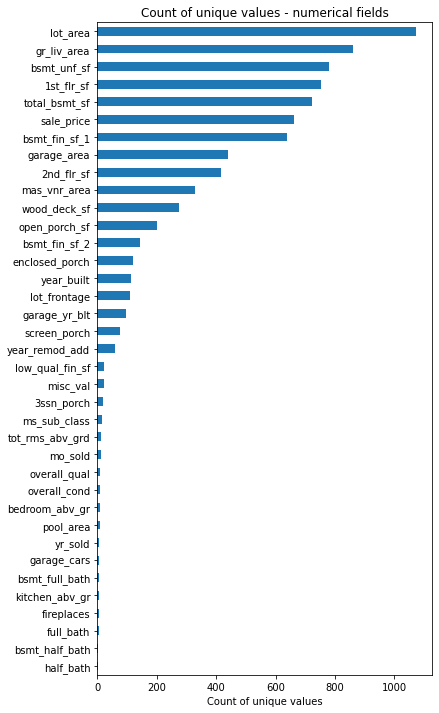

In [114]:
plt.figure(figsize=(6,12))
plt.title('Count of unique values - numerical fields')
train.select_dtypes(include=['float64', 'int64']).apply(lambda x: len(x.unique())).sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Count of unique values')
plt.show()

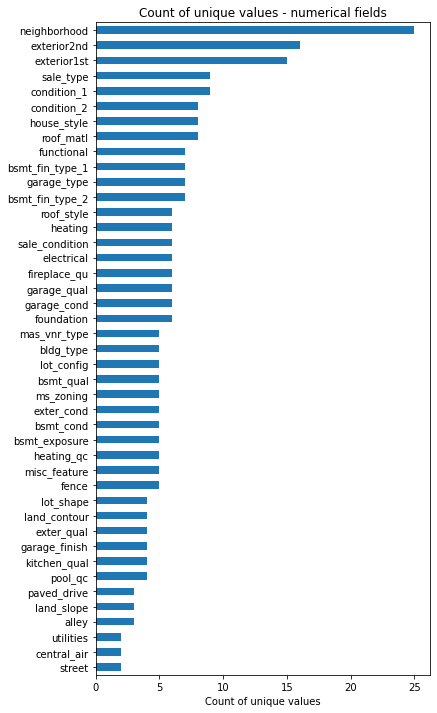

In [115]:
plt.figure(figsize=(6,12))
plt.title('Count of unique values - numerical fields')
train.select_dtypes(exclude=['float64', 'int64']).apply(lambda x: len(x.unique())).sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Count of unique values')
plt.show()

In [116]:
# TODO Remove features with less than n unique values

cat_columns = train.select_dtypes(include=object).columns.to_list()
num_columns = train.select_dtypes(include=['float64', 'int64']).columns.to_list()

print(f'There are {len(cat_columns)} categorical fields:\n{cat_columns}')
print(f'There are {len(num_columns)} numerical fields:\n{num_columns}')

# Add ms_sub_class to categorical fields
cat_columns.append('ms_sub_class')
num_columns.remove('ms_sub_class')

print(f'There are {len(cat_columns)} categorical fields:\n{cat_columns}')
print(f'There are {len(num_columns)} numerical fields:\n{num_columns}')

# Convert all categorical variables to object
train[cat_columns] = train[cat_columns].astype(object)
test[cat_columns] = test[cat_columns].astype(object)

Categorical fields:
['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior1st', 'exterior2nd', 'mas_vnr_type', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type_1', 'bsmt_fin_type_2', 'heating', 'heating_qc', 'central_air', 'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'pool_qc', 'fence', 'misc_feature', 'sale_type', 'sale_condition']
Numerical fields:
['ms_sub_class', 'lot_frontage', 'lot_area', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'mas_vnr_area', 'bsmt_fin_sf_1', 'bsmt_fin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abv_gr', 'kitchen_abv

## Missing Values

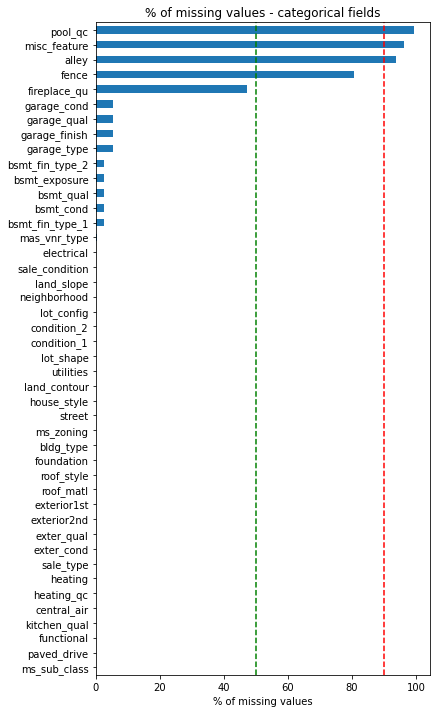

In [134]:
plt.figure(figsize=(6,12))
plt.title('% of missing values - categorical fields')
plt.axvline(x=50, color='g', linestyle='--')
plt.axvline(x=90, color='r', linestyle='--')
train\
    .select_dtypes(include=object)\
    .apply(lambda x: x.isnull().mean()*100)\
    .sort_values(ascending=True)\
    .plot(kind='barh')

plt.xlabel('% of missing values')
plt.show()

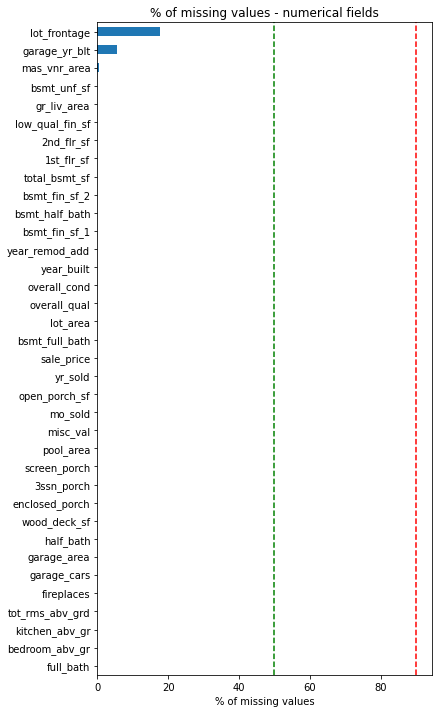

In [135]:
plt.figure(figsize=(6,12))
plt.title('% of missing values - numerical fields')
plt.axvline(x=50, color='g', linestyle='--')
plt.axvline(x=90, color='r', linestyle='--')
train\
    .select_dtypes(exclude=object)\
    .apply(lambda x: x.isnull().mean()*100)\
    .sort_values(ascending=True)\
    .plot(kind='barh')

plt.xlabel('% of missing values')
plt.show()

In [138]:
MISSING_THRESHOLD_DROP = 0.90

In [117]:
cat_columns

['ms_zoning',
 'street',
 'alley',
 'lot_shape',
 'land_contour',
 'utilities',
 'lot_config',
 'land_slope',
 'neighborhood',
 'condition_1',
 'condition_2',
 'bldg_type',
 'house_style',
 'roof_style',
 'roof_matl',
 'exterior1st',
 'exterior2nd',
 'mas_vnr_type',
 'exter_qual',
 'exter_cond',
 'foundation',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmt_fin_type_1',
 'bsmt_fin_type_2',
 'heating',
 'heating_qc',
 'central_air',
 'electrical',
 'kitchen_qual',
 'functional',
 'fireplace_qu',
 'garage_type',
 'garage_finish',
 'garage_qual',
 'garage_cond',
 'paved_drive',
 'pool_qc',
 'fence',
 'misc_feature',
 'sale_type',
 'sale_condition',
 'ms_sub_class']